1.1. Import Package yang diperlukan

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from pymongo import MongoClient
from imblearn.over_sampling import SMOTE
import joblib

from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

Connect to MongoDB

In [2]:
client = MongoClient("mongodb://localhost:27017/")
db = client["prediksi_diabetes"]
data = pd.DataFrame(list(db["data_diabetes"].find()))

# Drop kolom _id jika ada
if '_id' in data.columns:
    data.drop('_id', axis=1, inplace=True)

data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


### Data Cleaning

Tangani Missing Values

In [3]:
# Kolom yang tidak boleh punya nilai 0
invalid_zero_cols = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

# Ganti nilai 0 menjadi NaN
data[invalid_zero_cols] = data[invalid_zero_cols].replace(0, np.nan)

# Cek jumlah missing values
print("Missing values setelah diganti:")
print(data.isnull().sum())

Missing values setelah diganti:
Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64


4.2 Hapus Kolom dengan Banyak Missing dan Korelasi Rendah

In [4]:
data.drop(['Insulin', 'SkinThickness', 'DiabetesPedigreeFunction'], axis=1, inplace=True)
print(data.columns)

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'BMI', 'Age', 'Outcome'], dtype='object')


kolom Insulin dan SkinThickness memiliki banyak nilai 0, yang artinya banyak data yang tidak valid dan juga memerlukan alat laboratorium untuk pengukurannya yang sulit dilakukan di fasilitas kesehatan terbatas.

Kolom DiabetesPedigreeFunction juga memiliki korelasi rendah dengan hasil diagnosis dan tidak mudah diukur secara langsung. maka dari itu, ketiga fitur ini tidak kami gunakan di modeling dan kami hapus.

4.3 Imputasi Missing Values

Karena ada fitur yang memiliki nilai 0 tidak valid. Untuk menangani hal ini, kami melakukan imputasi menggunakan KNNImputer.


In [5]:
from sklearn.impute import KNNImputer
# Pisahkan fitur dan target
X_temp = data.drop(columns='Outcome')
y_temp = data['Outcome']

# imputasi (mencari 5 tetangga terdekat dari setiap data yang hilang, lalu menghitung rata-rata)
imputer = KNNImputer(n_neighbors=5)
X_imputed = imputer.fit_transform(X_temp)

# Buat ulang DataFrame
columns = X_temp.columns
data_imputed = pd.DataFrame(X_imputed, columns=columns)
data_imputed['Outcome'] = y_temp

# Simpan hasil imputasi ke variabel akhir
data = data_imputed

# Cek missing
print("Cek missing setelah imputasi:")
print(data.isnull().sum())

print("Jumlah data sebelum drop duplikat:", data.shape[0])
data.drop_duplicates(inplace=True)
print("Jumlah data setelah drop duplikat:", data.shape[0])

Cek missing setelah imputasi:
Pregnancies      0
Glucose          0
BloodPressure    0
BMI              0
Age              0
Outcome          0
dtype: int64
Jumlah data sebelum drop duplikat: 768
Jumlah data setelah drop duplikat: 768


Imputasi adalah proses mengganti nilai kosong dengan nilai yang diperkirakan berdasarkan data lain. KNNImputer bekerja dengan cara mencari 5 tetangga terdekat (n_neighbors=5) dari setiap data yang hilang, lalu menghitung rata-rata dari nilai mereka untuk mengisi kekosongan tersebut.

Hasilnya, seluruh nilai kosong berhasil diisi dengan nilai yang masuk akal, dan tidak ada lagi missing value dalam data.

4.5 Tangani Outlier 

Winsorizing adalah teknik untuk mengurangi efek outlier dengan cara mengganti nilai di bawah batas bawah persentil 5% dan di atas batas atas persentil 95% menjadi nilai batas tersebut. 
Tujuannya agar data lebih stabil dan model tidak terpengaruh outlier.

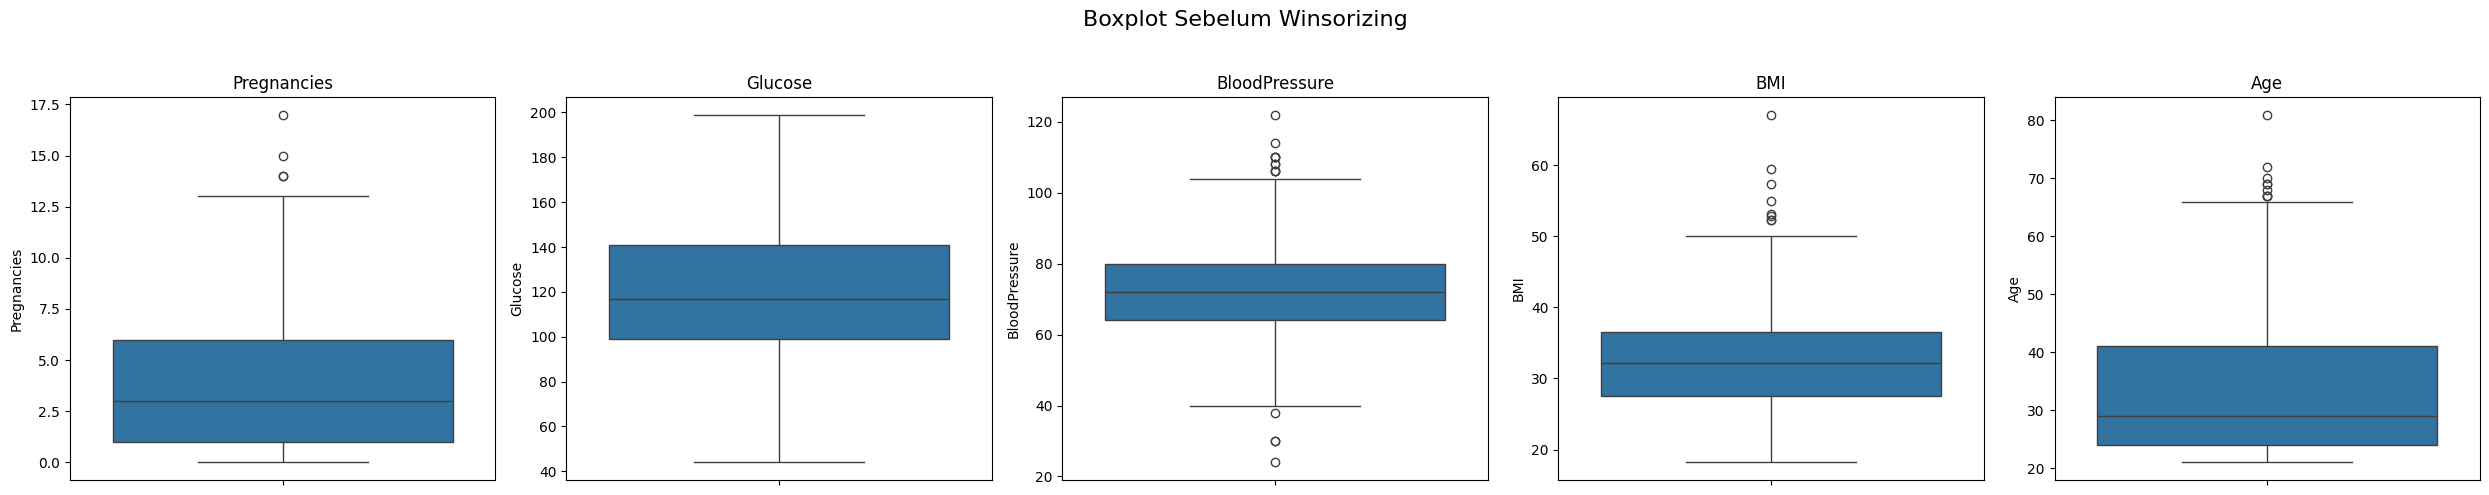

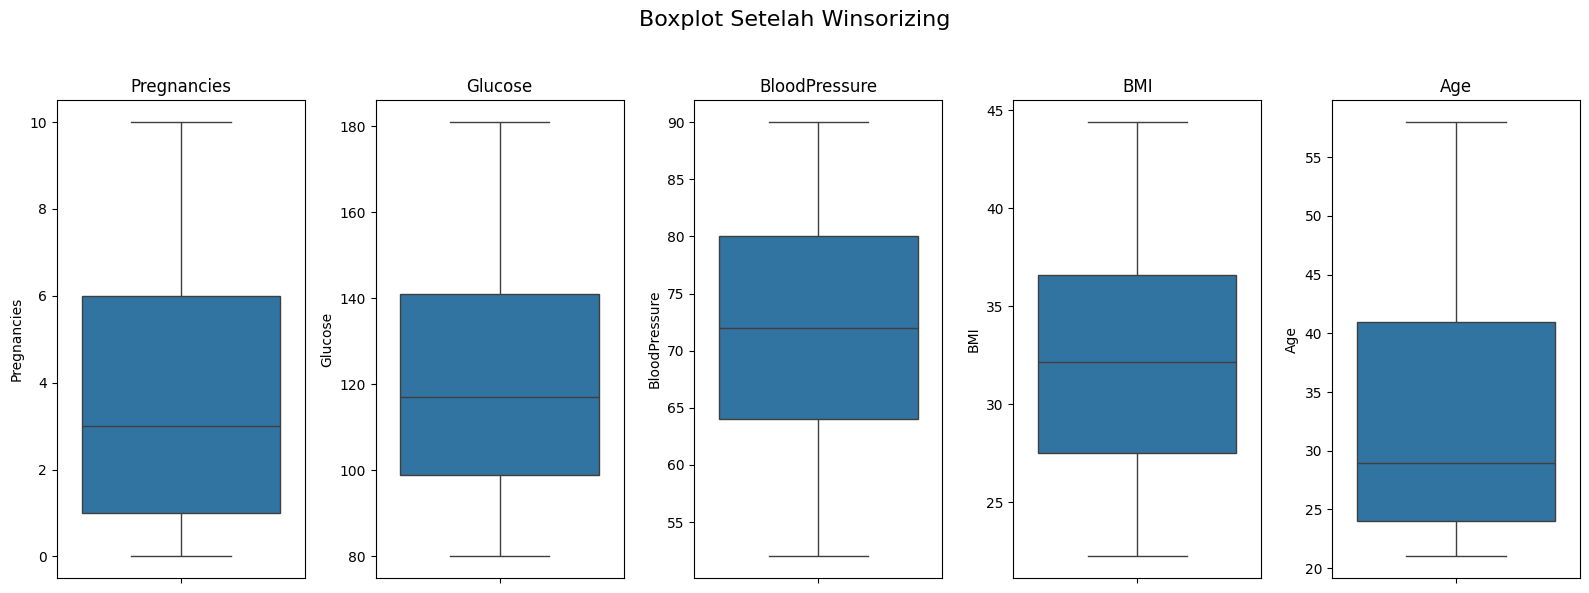

In [6]:
# Fungsi winsorizing
def winsorize_outliers(df, cols, lower_percentile=0.05, upper_percentile=0.95):
    df_winsor = df.copy()
    for col in cols:
        # Cari batas bawah (persentil 5%) dan batas atas (persentil 95%) untuk kolom
        lower_bound = df[col].quantile(lower_percentile)
        upper_bound = df[col].quantile(upper_percentile)
        # Ganti nilai yang lebih kecil dari batas bawah dengan nilai batas bawah
        df_winsor[col] = np.where(df_winsor[col] < lower_bound, lower_bound, df_winsor[col])
         # Ganti nilai yang lebih besar dari batas atas dengan nilai batas atas
        df_winsor[col] = np.where(df_winsor[col] > upper_bound, upper_bound, df_winsor[col])
    return df_winsor

# Pilih kolom numerik kecuali target (Outcome)
numerical_cols = [col for col in data.select_dtypes(include=['float64', 'int64']).columns 
                  if col not in ['Outcome']]

# Plot boxplot sebelum winsorizing
plt.figure(figsize=(25, 5))
plt.suptitle('Boxplot Sebelum Winsorizing', fontsize=16)
for i, col in enumerate(numerical_cols):
    plt.subplot(1, len(numerical_cols), i+1)
    sns.boxplot(y=data[col])
    plt.title(col)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Lakukan winsorizing
data_winsor = winsorize_outliers(data, numerical_cols)

# Plot boxplot setelah winsorizing
plt.figure(figsize=(16, 6))
plt.suptitle('Boxplot Setelah Winsorizing', fontsize=16)
for i, col in enumerate(numerical_cols):
    plt.subplot(1, len(numerical_cols), i+1)
    sns.boxplot(y=data_winsor[col])
    plt.title(col)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# 5. Data Transformation

5.1 Persiapan Data

In [7]:
X = data.drop(['Outcome'], axis=1)
y = data['Outcome']

# distribusi target awal
print("Distribusi kelas awal:")
print(y.value_counts())

Distribusi kelas awal:
Outcome
0    500
1    268
Name: count, dtype: int64


In [8]:
# 2. Pemisahan data menjadi train dan test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Melihat distribusi kelas pada data training
print("\nDistribusi kelas pada data training:")
print(pd.Series(y_train).value_counts())


Distribusi kelas pada data training:
Outcome
0    401
1    213
Name: count, dtype: int64


In [9]:
# 3. Normalisasi data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
# Fitting scaler HANYA pada data training
X_train_scaled = scaler.fit_transform(X_train)
# Transform data test 
X_test_scaled = scaler.transform(X_test)

SMOTE adalah teknik untuk menyeimbangkan jumlah data pada kelas minoritas dengan membuat data baru dengan cara memilih data minoritas, mencari tetangga terdekatnya, lalu membuat data baru di antara keduanya

In [10]:
# 4. SMOTE pada data training SETELAH train-test split
from imblearn.over_sampling import SMOTE
from collections import Counter
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

print("\nDistribusi kelas setelah SMOTE pada data training):")
print(sorted(Counter(y_train_resampled).items()))


Distribusi kelas setelah SMOTE pada data training):
[(0, 401), (1, 401)]


C:\Users\mifta\AppData\Local\Temp\ipykernel_17944\3468694882.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  a = sns.countplot(x='Outcome', data=data, palette='Set2', ax=ax[0])
C:\Users\mifta\AppData\Local\Temp\ipykernel_17944\3468694882.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  a = sns.countplot(x=y_series, palette='Set2', ax=ax[1])


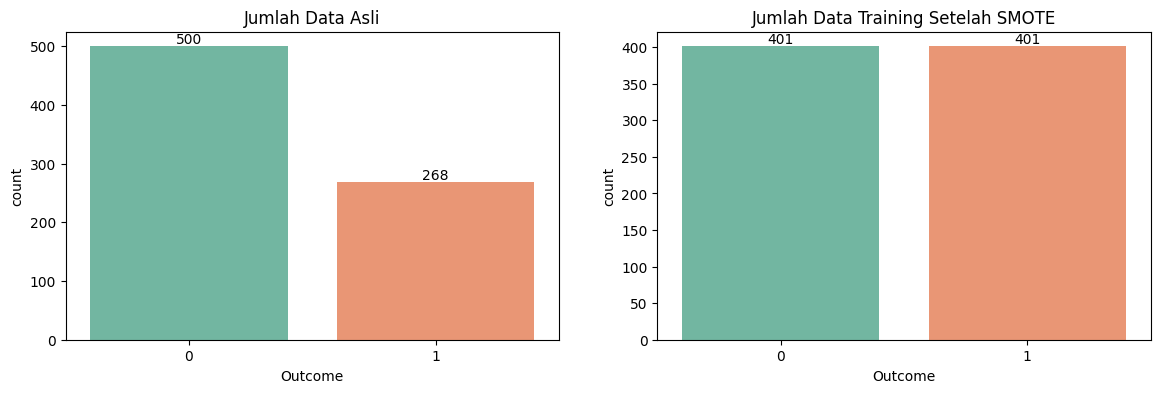

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
# Data asli
a = sns.countplot(x='Outcome', data=data, palette='Set2', ax=ax[0])
for j in a.containers:
    a.bar_label(j, label_type='edge')
ax[0].set_title('Jumlah Data Asli')

# Data training setelah SMOTE
y_series = pd.Series(y_train_resampled, name='Outcome')
a = sns.countplot(x=y_series, palette='Set2', ax=ax[1])
for j in a.containers:
    a.bar_label(j, label_type='edge')
ax[1].set_title('Jumlah Data Training Setelah SMOTE')
plt.show()

In [12]:
# Informasi ukuran data
print('\nTotal data asli X:', len(X))
print('Total data asli y:', len(y))
print('=====================================')
print('Total data X_train awal:', len(X_train))
print('Total data y_train awal:', len(y_train))
print('Total data X_train setelah SMOTE:', len(X_train_resampled))
print('Total data y_train setelah SMOTE:', len(y_train_resampled))
print('=====================================')
print('Total data X_test:', len(X_test))
print('Total data y_test:', len(y_test))


Total data asli X: 768
Total data asli y: 768
Total data X_train awal: 614
Total data y_train awal: 614
Total data X_train setelah SMOTE: 802
Total data y_train setelah SMOTE: 802
Total data X_test: 154
Total data y_test: 154


In [13]:
# Simpan ke file CSV
data.to_csv("data_diabetes_clean.csv", index=False)


### Modeling

In [14]:
models = {
    "Logistic Regression": LogisticRegression(random_state=42, solver='liblinear'),
    "SVM": SVC(kernel='linear', random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gaussian Naive Bayes": GaussianNB()
}

results = {}
# Loop buat latih dan uji semua model
for name, model in models.items():
   # Latih model pakai data training yang sudah diseimbangkan
    model.fit(X_train_resampled, y_train_resampled)
    # Evaluasi menggunakan data testing
    y_pred = model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = accuracy

print("\nHasil Evaluasi Model:")
for name, accuracy in results.items():
    print(f"{name}: Accuracy = {accuracy:.4f}")

best_model_name = max(results, key=results.get)
print(f"\nModel Terbaik Berdasarkan Akurasi: {best_model_name} (Accuracy = {results[best_model_name]:.4f})")


Hasil Evaluasi Model:
Logistic Regression: Accuracy = 0.7078
SVM: Accuracy = 0.7078
Random Forest: Accuracy = 0.7468
Gaussian Naive Bayes: Accuracy = 0.7403

Model Terbaik Berdasarkan Akurasi: Random Forest (Accuracy = 0.7468)


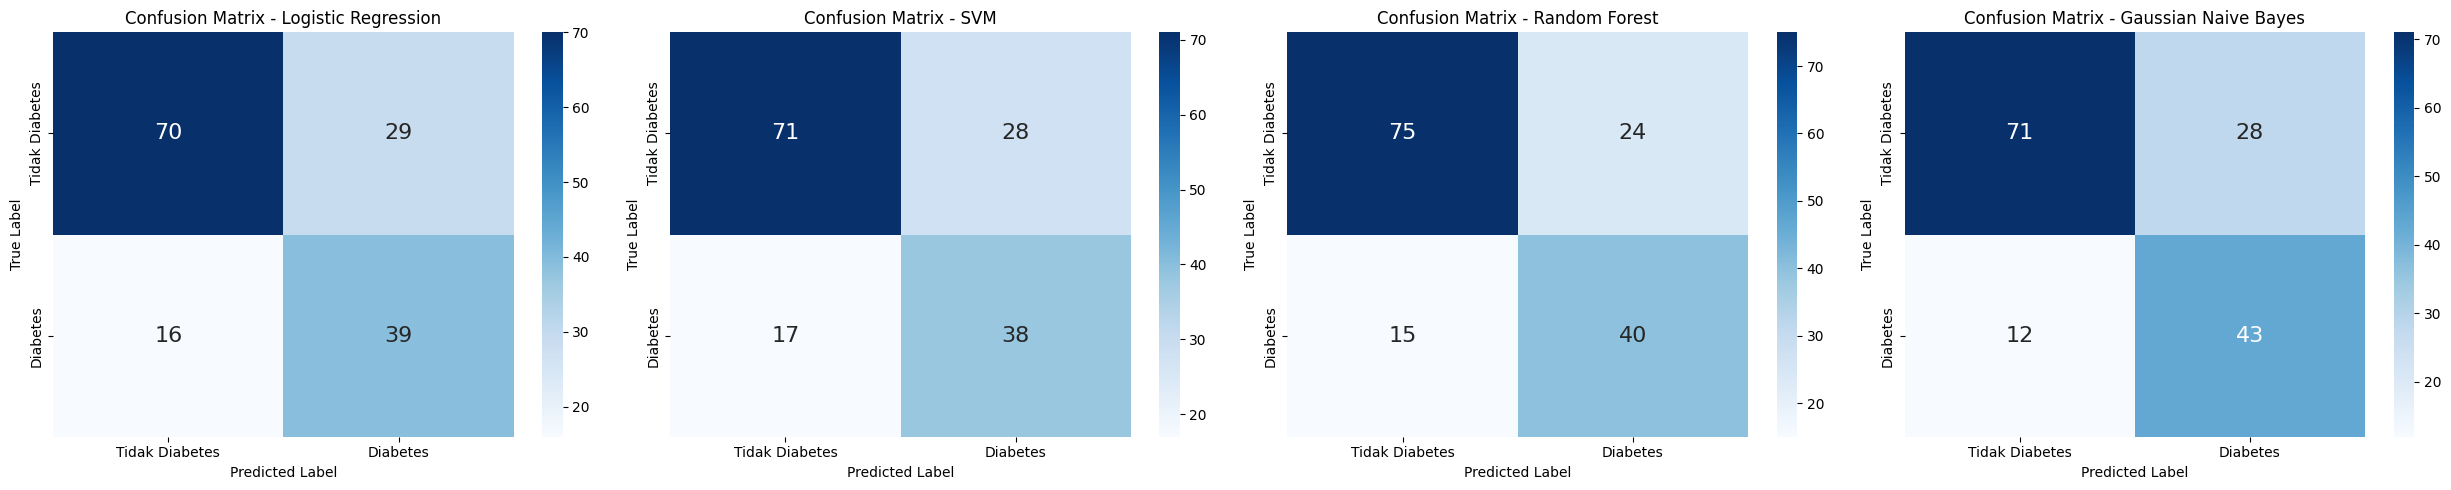

In [22]:
from sklearn.metrics import confusion_matrix

# Pilih model-model yang udah dilatih sebelumnya untuk dibandingkan
models_to_compare = {
    "Logistic Regression": models["Logistic Regression"],
    "SVM": models["SVM"],  # Tambahkan SVM
    "Random Forest": models["Random Forest"],
    "Gaussian Naive Bayes": models["Gaussian Naive Bayes"]
}

# Buat subplots untuk setiap confusion matrix
fig, axes = plt.subplots(1, len(models_to_compare), figsize=(25, 5))  # Sesuaikan ukuran figure

# Loop tiap model buat bikin confusion matrix
for i, (name, model) in enumerate(models_to_compare.items()):
    # Prediksi hasil dari data test
    y_pred = model.predict(X_test_scaled)

    # hitung confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Visualisasikan confusion matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Tidak Diabetes', 'Diabetes'],
                yticklabels=['Tidak Diabetes', 'Diabetes'],
                annot_kws={"size": 16},
                ax=axes[i])
    axes[i].set_xlabel('Predicted Label')
    axes[i].set_ylabel('True Label')
    axes[i].set_title(f'Confusion Matrix - {name}')

plt.tight_layout()
plt.show()

evaluasi model menggunakan teknik Cross Validation, yaitu proses untuk menguji keakuratan model secara menyeluruh.

In [16]:
from sklearn.model_selection import cross_val_score

for name, model in models.items():
    cv_scores = cross_val_score(model, X_train_resampled, y_train_resampled, cv=5, scoring='accuracy') 
    print(f"\n{name}: CV Accuracy Scores = {cv_scores}")
    print(f"{name}: Mean CV Accuracy = {cv_scores.mean():.4f}")


Logistic Regression: CV Accuracy Scores = [0.73913043 0.76397516 0.73125    0.73125    0.775     ]
Logistic Regression: Mean CV Accuracy = 0.7481

SVM: CV Accuracy Scores = [0.74534161 0.76397516 0.7125     0.73125    0.775     ]
SVM: Mean CV Accuracy = 0.7456

Random Forest: CV Accuracy Scores = [0.75776398 0.7826087  0.8        0.85625    0.8875    ]
Random Forest: Mean CV Accuracy = 0.8168

Gaussian Naive Bayes: CV Accuracy Scores = [0.72049689 0.74534161 0.7375     0.73125    0.7625    ]
Gaussian Naive Bayes: Mean CV Accuracy = 0.7394


data training yang sudah diseimbangkan di bagi menjadi 5 bagian. Lalu, model dilatih dan diuji sebanyak 5 kali, dengan data yang berbeda-beda. Tujuannya untuk melihat seberapa stabil model kalau diuji dengan data yang bervariasi.

In [17]:
best_rf = models["Random Forest"]  # Ambil model Random Forest
best_rf.fit(X_train_resampled, y_train_resampled)  # Latih pada seluruh data training

RandomForestClassifier(random_state=42)

In [18]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

y_pred = best_rf.predict(X_test_scaled)
print("\nEvaluasi Akhir pada Data Testing:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


Evaluasi Akhir pada Data Testing:
Accuracy: 0.7468
              precision    recall  f1-score   support

           0       0.83      0.76      0.79        99
           1       0.62      0.73      0.67        55

    accuracy                           0.75       154
   macro avg       0.73      0.74      0.73       154
weighted avg       0.76      0.75      0.75       154

[[75 24]
 [15 40]]


In [19]:
# Simpan model dan scaler
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(best_rf, 'best_random_forest_model.pkl')

['best_random_forest_model.pkl']

In [20]:
# Load model dan scaler
classifier = joblib.load('best_random_forest_model.pkl')
scaler = joblib.load('scaler.pkl')

# Data input pasien
input_data = (6, 148, 72, 33.6, 50)
feature_names = ['Pregnancies', 'Glucose', 'BloodPressure', 'BMI', 'Age']

# Buat DataFrame agar sesuai dengan fitur saat scaler dilatih
input_df = pd.DataFrame([input_data], columns=feature_names)

# Scaling dan prediksi
input_scaled = scaler.transform(input_df)
prediction = classifier.predict(input_scaled)

print(f"Prediksi: {prediction[0]}")

if prediction[0] == 0:
    print('✅ Pasien tidak terkena diabetes')
else:
    print('⚠️ Pasien terkena diabetes')

Prediksi: 1
⚠️ Pasien terkena diabetes


In [21]:
# Data input pasien
input_data = (1, 85, 66, 26.6, 30)  
feature_names = ['Pregnancies', 'Glucose', 'BloodPressure', 'BMI', 'Age']

# Buat DataFrame agar sesuai dengan fitur saat scaler dilatih
input_df = pd.DataFrame([input_data], columns=feature_names)

# Scaling dan prediksi
input_scaled = scaler.transform(input_df)
prediction = classifier.predict(input_scaled)

# Output prediksi
print(f"Prediksi: {prediction[0]}")

if prediction[0] == 0:
    print('✅ Pasien tidak terkena diabetes')
else:
    print('⚠️ Pasien terkena diabetes')

Prediksi: 0
✅ Pasien tidak terkena diabetes
